# Automated Machine Learning (AutoML)
---

Recall: Optimization is the process of finding the best solution from all feasible solutions. In machine learning, we often aim to minimize a loss function or maximize a performance metric. The general form of an optimization problem can be expressed as:



## Introduction to AutoML

### What is AutoML?
Automated Machine Learning provides methods and processes to make Machine Learning available for non-Machine Learning experts, to improve efficiency of Machine Learning and to accelerate research on Machine Learning.

Machine learning (ML) has achieved considerable successes in recent years and an ever-growing number of disciplines rely on it. However, this success crucially relies on human machine learning experts to perform the following tasks:

* Preprocess and clean the data.
* Select and construct appropriate features.
* Select an appropriate model family.
* Optimize model hyperparameters.
* Design the topology of neural networks (if deep learning is used).
* Postprocess machine learning models.
* Critically analyze the results obtained.

As the complexity of these tasks is often beyond non-ML-experts, the rapid growth of machine learning applications has created a demand for off-the-shelf machine learning methods that can be used easily and without expert knowledge. We call the resulting research area that targets progressive automation of machine learning AutoML.

## Preparing the Dataset

We use the diabetes dataset from OpenML for a binary classification task. This dataset is well-suited for benchmarking machine learning models.

In [1]:
import openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_diabetes_dataset():
    dataset = openml.datasets.get_dataset(37)  # Diabetes dataset
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
    le = LabelEncoder()
    y = le.fit_transform(y.tolist())
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_diabetes_dataset()

/tmp/ipykernel_306557/4024864023.py:6: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(37)  # Diabetes dataset


## TPOT: Optimizing Pipelines with Genetic Programming

### What is TPOT?

TPOT is a genetic programming-based AutoML tool that searches for the best machine learning pipeline. It optimizes combinations of preprocessing steps, feature selection techniques, and models to maximize performance on your dataset. TPOT is especially valuable for its ability to export pipelines, making its results interpretable and reusable.


![TPOT Logo](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-ml-pipeline.png)

![TPOT Show](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-pipeline-example.png)

In [2]:
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(generations=5, population_size=50, cv=5, random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)
print("TPOT Best Pipeline:", pipeline_optimizer.fitted_pipeline_)
print("TPOT Test Accuracy:", pipeline_optimizer.score(X_test, y_test))

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7817806210848993

Generation 2 - Current best internal CV score: 0.7817806210848993

Generation 3 - Current best internal CV score: 0.7834199653471945

Generation 4 - Current best internal CV score: 0.7834199653471945

Generation 5 - Current best internal CV score: 0.7834199653471945

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.5, min_samples_leaf=3, min_samples_split=14, n_estimators=100)
TPOT Best Pipeline: Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(max_features=0.5, min_samples_leaf=3,
                                      min_samples_split=14, random_state=42))])
TPOT Test Accuracy: 0.7727272727272727


In [3]:
pipeline_optimizer.export("tpot_diabetes_pipeline.py")  # Save the best pipeline for future use.

# Print search history from TPOT
with open("tpot_diabetes_pipeline.py", "r") as f:
    print("Saved TPOT pipeline:\n", f.read())

Saved TPOT pipeline:
 import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.7834199653471945
exported_pipeline = ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.5, min_samples_leaf=3, min_samples_split=14, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)



## AutoGluon: Flexible and Automated Machine Learning

### What is AutoGluon?

AutoGluon provides a flexible AutoML framework for both tabular and other types of data. It simplifies the process of building and optimizing models, and it provides a leaderboard of all evaluated models. AutoGluon also offers insights into feature importances, enabling better interpretability.

### Running AutoGluon

In [4]:
from autogluon.tabular import TabularPredictor

train_data = X_train.copy()
train_data['target'] = y_train
test_data = X_test.copy()
test_data['target'] = y_test

predictor = TabularPredictor(label='target', verbosity=2).fit(train_data)
performance = predictor.evaluate(test_data)
print("AutoGluon Performance:", performance)

No path specified. Models will be saved in: "AutogluonModels/ag-20250104_115004"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.5
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #52-Ubuntu SMP PREEMPT_DYNAMIC Thu Dec  5 13:09:44 UTC 2024
CPU Count:          8
Memory Avail:       21.82 GB / 31.07 GB (70.2%)
Disk Space Avail:   587.53 GB / 915.32 GB (64.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_qual

AutoGluon Performance: {'accuracy': 0.7272727272727273, 'balanced_accuracy': 0.6707070707070707, 'mcc': 0.37618305065572016, 'roc_auc': 0.7731864095500458, 'f1': 0.5531914893617021, 'precision': 0.6666666666666666, 'recall': 0.4727272727272727}


### Visualization with AutoGluon


In [5]:
predictor.leaderboard(silent=False)

                  model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   0.813008    accuracy       0.000417  0.242966                0.000417           0.242966            1       True         13
1   WeightedEnsemble_L2   0.813008    accuracy       0.000852  0.303956                0.000436           0.060990            2       True         14
2              CatBoost   0.788618    accuracy       0.000378  0.243782                0.000378           0.243782            1       True          7
3              LightGBM   0.780488    accuracy       0.000335  0.123313                0.000335           0.123313            1       True          4
4            LightGBMXT   0.780488    accuracy       0.000374  0.187928                0.000374           0.187928            1       True          3
5               XGBoost   0.780488    accuracy       0.001568  0.108020                0.001568     

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.813008,accuracy,0.000417,0.242966,0.000417,0.242966,1,True,13
1,WeightedEnsemble_L2,0.813008,accuracy,0.000852,0.303956,0.000436,0.060990,2,True,14
2,CatBoost,0.788618,accuracy,0.000378,0.243782,0.000378,0.243782,1,True,7
3,LightGBM,0.780488,accuracy,0.000335,0.123313,0.000335,0.123313,1,True,4
4,LightGBMXT,0.780488,accuracy,0.000374,0.187928,0.000374,0.187928,1,True,3
5,XGBoost,0.780488,accuracy,0.001568,0.108020,0.001568,0.108020,1,True,11
6,NeuralNetFastAI,0.780488,accuracy,0.004158,0.384664,0.004158,0.384664,1,True,10
7,NeuralNetTorch,0.756098,accuracy,0.003985,0.861763,0.003985,0.861763,1,True,12
8,ExtraTreesGini,0.747967,accuracy,0.022269,0.254299,0.022269,0.254299,1,True,8
9,RandomForestEntr,0.747967,accuracy,0.022431,0.257232,0.022431,0.257232,1,True,6


### Feature importances


In [6]:
importances = predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 8 features using 154 rows with 5 shuffle sets...
	0.16s	= Expected runtime (0.03s per shuffle set)
	0.04s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [7]:
importances

,importance,stddev,p_value,n,p99_high,p99_low
plas,0.109091,0.028821,0.000534,5,0.168434,0.049748
mass,0.055844,0.027778,0.005431,5,0.113040,-0.001352
pedi,0.011688,0.015503,0.083552,5,0.043609,-0.020233
age,0.011688,0.023141,0.160932,5,0.059336,-0.035959
pres,0.002597,0.003557,0.088904,5,0.009921,-0.004726
preg,0.001299,0.012491,0.413782,5,0.027017,-0.024419
insu,-0.002597,0.005808,0.813050,5,0.009361,-0.014556
skin,-0.029870,0.024555,0.973508,5,0.020690,-0.080430


## TabPFN: Probabilistic Neural Networks for Tabular Data

TabPFN is designed specifically for tabular data. It leverages a pretrained Transformer-based neural network to make fast, accurate, and probabilistic predictions. Unlike other AutoML tools, TabPFN emphasizes speed and uncertainty quantification, making it a strong choice for scenarios requiring quick decisions.


### Running TabPFN


In [8]:
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score

clf = TabPFNClassifier(device='cpu')  # Use 'cuda' if GPU is available
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("TabPFN Test Accuracy:", accuracy_score(y_test, y_pred))

/home/boshkokoloski/miniconda3/lib/python3.11/site-packages/tabpfn/scripts/model_builder.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state, optimizer_state, c

TabPFN Test Accuracy: 0.7662337662337663


## Comparing Results and Insights

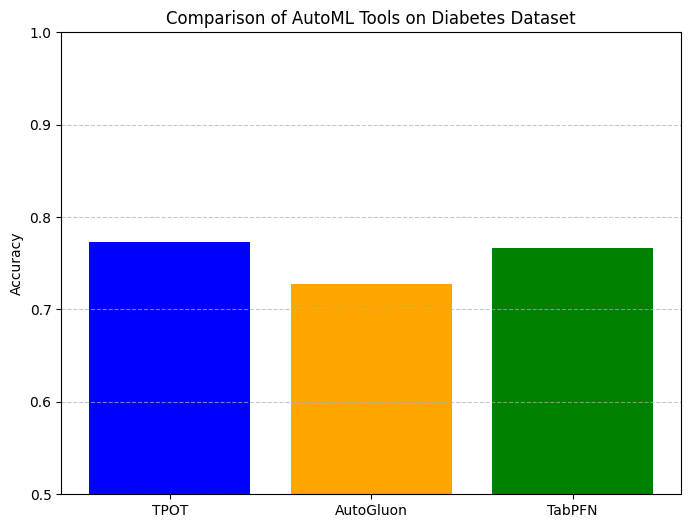

In [9]:
import matplotlib.pyplot as plt

accuracies = {
    'TPOT': pipeline_optimizer.score(X_test, y_test),
    'AutoGluon': performance['accuracy'],
    'TabPFN': accuracy_score(y_test, y_pred)
}

plt.figure(figsize=(8, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange', 'green'])
plt.title('Comparison of AutoML Tools on Diabetes Dataset')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()